<a href="https://colab.research.google.com/github/TonyN2060/Capstone-Project/blob/Branch_1/Copy_of_Capsone_Revised_draft_(9)_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning in Breast Cancer Detection

## Business Overview
In the domain of healthcare, accurate and early detection of breast cancer is crucial for improving patient outcomes and reducing mortality rates. Leveraging the power of deep learning, this project aims to revolutionize breast cancer prediction by developing a state-of-the-art predictive model. This model will utilize cutting-edge technologies and medical imaging data to enhance breast cancer diagnosis, ultimately advancing the quality of healthcare services.

## Problem Statement
The objective of this project is to design and implement a Deep Learning-Based Breast Cancer Prediction System (DL-BCPS) capable of analyzing medical imaging data, such as mammograms and ultrasound images, to predict the presence of breast cancer in patients. The DL-BCPS aims to improve the accuracy and efficiency of breast cancer diagnosis, providing healthcare professionals with a valuable tool for early detection and intervention. This initiative seeks to contribute to reducing breast cancer-related mortality rates and enhancing the overall quality of healthcare in the region.

## Main Objective
The primary objective of this project is to create a multiclass classification model that can accurately predict the presence of breast cancer through medical imaging data. This model will enable early detection of breast cancer, facilitating timely medical intervention, improving patient outcomes, and assisting healthcare professionals in diagnosis and decision-making.

### Specific Objectives
- To develop a deep learning model using medical imaging data that can achieve a sensitivity of at least 95% and a specificity of at least 90% in accurately predicting the presence of breast cancer.

- To determine specific parameters and features within the medical imaging data that are most indicative of early-stage breast cancer to improve the model's ability to detect cancer at its earliest stages.

- To establish a timeline for medical intervention based on the model's predictions, ensuring that cases with a high likelihood of breast cancer are flagged promptly for further examination and diagnosis.

- To implement a user-friendly interface for healthcare professionals to upload medical images and receive predictions from the DL-BCPS.

## Success Criteria
The success of the project will be measured based on the following criteria:

- Achieve a classification accuracy of at least 85% on the test dataset.
- The model should have a high F1-score to ensure a balance between precision and recall.
- The model should demonstrate good generalization by performing well on unseen data.

## The Dataset

We have one dataset, consisting of mammography images from the INbreast database. This database was originally collected from Centro Hospitalar de S. Joao (CHSJ), Breast center, Porto. The data is grouped into three sets:
- Benign: This set contains 437 images.
- Malignant: This set contains 210 images.
- Normal: This set contains 133 images.

## Importing libraries

In [ ]:
#pip install --upgrade numpy

In [ ]:
#pip install --upgrade h5py

In [2]:
#import relevant libraries
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2, DenseNet121
from tensorflow.keras.optimizers import Adam
from itertools import chain
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import glob
import warnings

## Loading dataset

In [3]:
# loading the dataset from the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Defining paths to the directories
normal_path = '/content/drive/MyDrive/Dataset_Ultrasound_breast_images-20231003T104543Z-001/Dataset_Ultrasound_breast_images/normal'
benign_path = '/content/drive/MyDrive/Dataset_Ultrasound_breast_images-20231003T104543Z-001/Dataset_Ultrasound_breast_images/benign'
malignant_path = '/content/drive/MyDrive/Dataset_Ultrasound_breast_images-20231003T104543Z-001/Dataset_Ultrasound_breast_images/malignant'
image_dir = '/content/drive/MyDrive/Dataset_Ultrasound_breast_images-20231003T104543Z-001/Dataset_Ultrasound_breast_images'

## Data Understanding

This section explores and analyzes the dataset to understand its characteristics and properties. This includes:
- Visualizing images from each category
- Examining the distribution of classes
- Understanding the format and dimensions of the images
- Identifying any potential issues such as missing or corrupt data

### Visualize sample images

We begin by visualizing some of the ultrasound images from each category to gain more insight into the data. Through this visualization, we aim to identify any visible patterns or characteristics that differentiate each category.

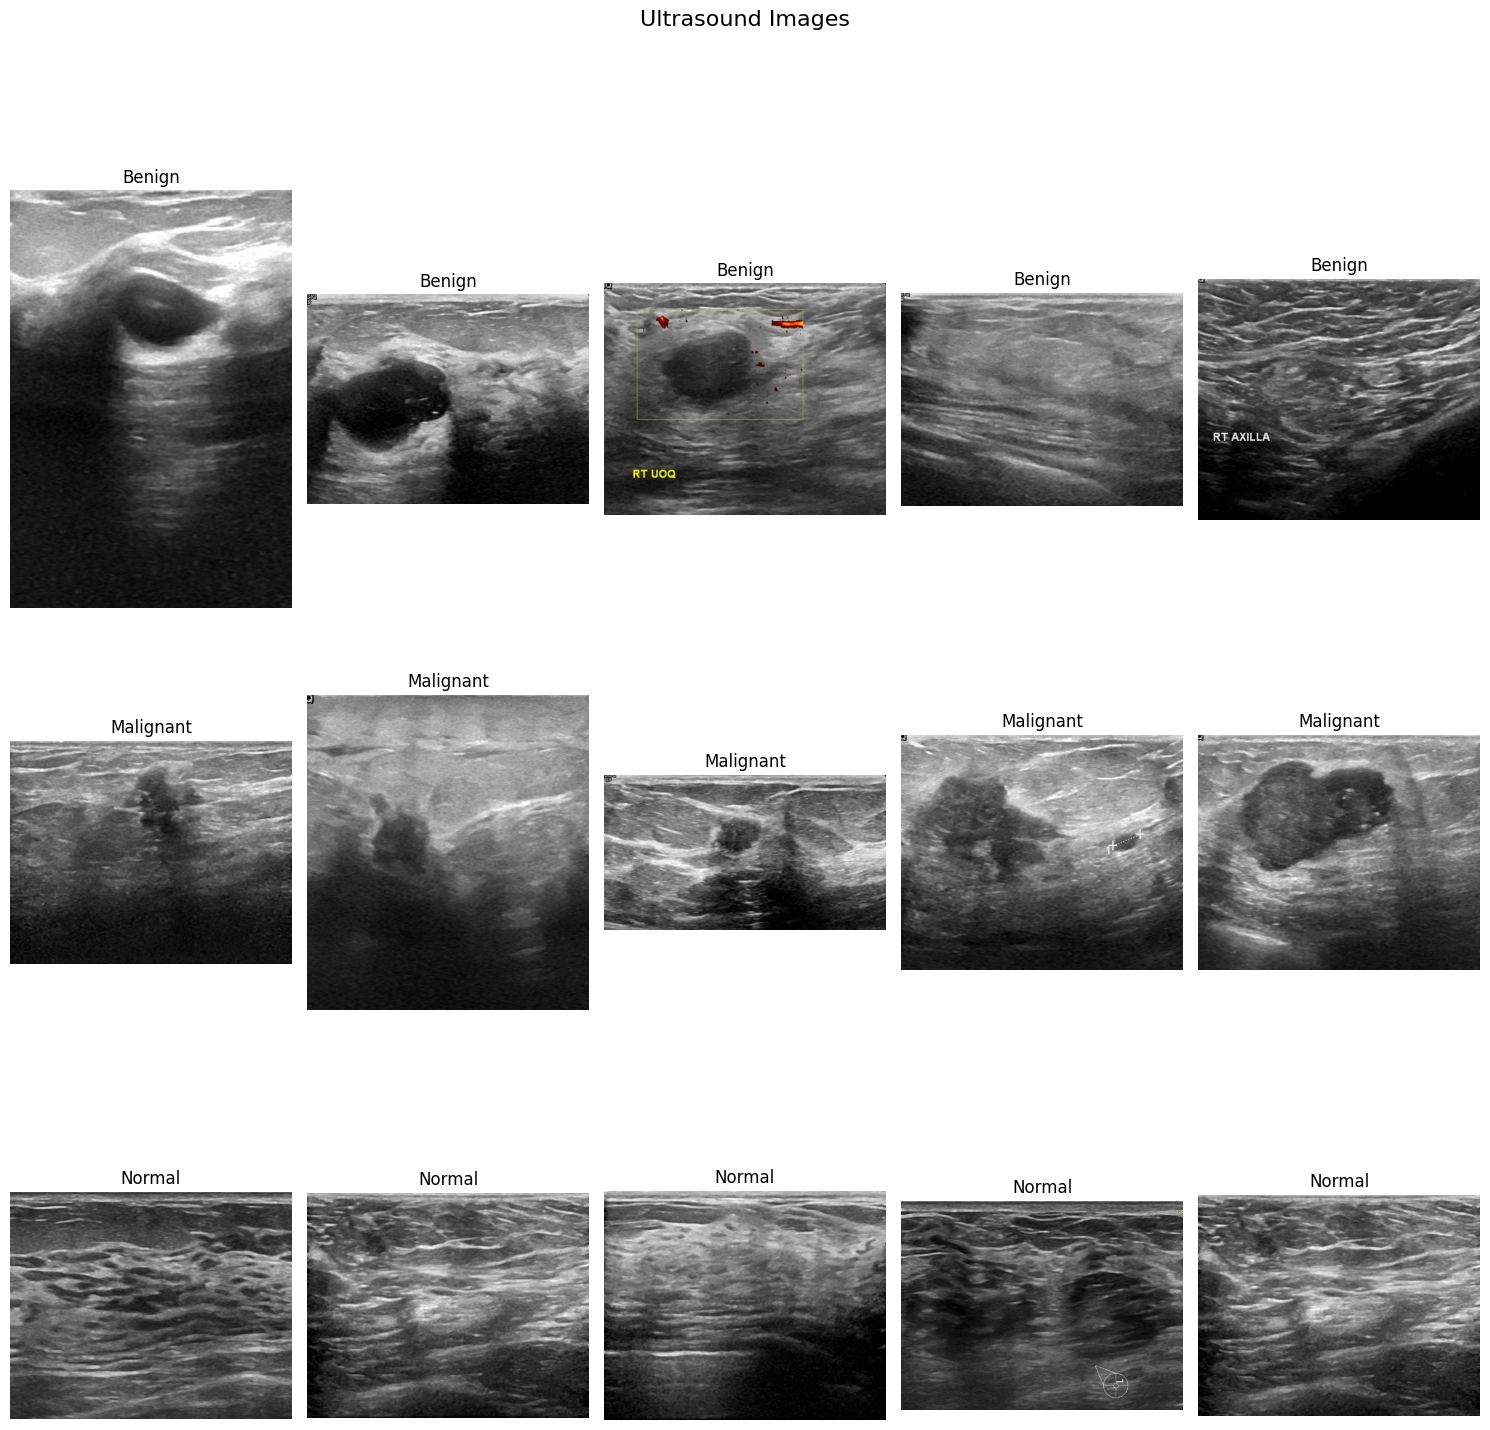

In [5]:
# Create dictionary for categories and paths
categories_paths = {
    'normal': normal_path,
    'benign': benign_path,
    'malignant': malignant_path
}

# Randomly sample 5 images from each category
normal_images = [os.path.join(normal_path, fname) for fname in random.sample(os.listdir(normal_path), 5)]
benign_images = [os.path.join(benign_path, fname) for fname in random.sample(os.listdir(benign_path), 5)]
malignant_images = [os.path.join(malignant_path, fname) for fname in random.sample(os.listdir(malignant_path), 5)]

# Plot images
fig, axes = plt.subplots(3, 5, figsize=(15, 15))
fig.suptitle('Ultrasound Images', fontsize=16, y=1.05)

# Display benign images
for ax, img_path in zip(axes[0], benign_images):
    img = mpimg.imread(img_path)
    ax.imshow(img, cmap='gray')
    ax.set_title("Benign")
    ax.axis('off')

# Display malignant images
for ax, img_path in zip(axes[1], malignant_images):
    img = mpimg.imread(img_path)
    ax.imshow(img, cmap='gray')
    ax.set_title("Malignant")
    ax.axis('off')

# Display normal images
for ax, img_path in zip(axes[2], normal_images):
    img = mpimg.imread(img_path)
    ax.imshow(img, cmap='gray')
    ax.set_title("Normal")
    ax.axis('off')

plt.tight_layout()
plt.show()


Observation:
-
-
-

### View image sizes

In this section, we analyze the dimensions of the images in the dataset. Understanding the variation in image sizes will inform the decision on whether to resize images for model training and what target dimensions to use.

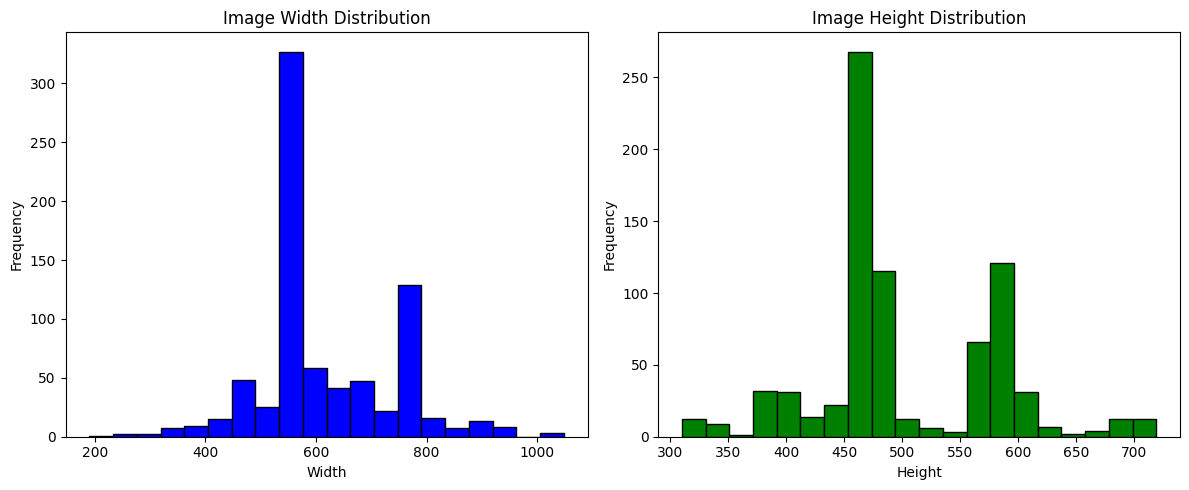

In [6]:
# Initialize lists to store widths and heights
widths = []
heights = []

# Loop over each category and path
for category, path in categories_paths.items():
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        # Read the image in grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # Get the dimensions
        h, w = img.shape
        widths.append(w)
        heights.append(h)

# Plot the Image Size Distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(widths, bins=20, color='blue', edgecolor='black')
axes[0].set_title('Image Width Distribution')
axes[0].set_xlabel('Width')
axes[0].set_ylabel('Frequency')

axes[1].hist(heights, bins=20, color='green', edgecolor='black')
axes[1].set_title('Image Height Distribution')
axes[1].set_xlabel('Height')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Pixel intensity distribution

In this section, we analyze the distribution of pixel intensities across the images in the dataset.

In [ ]:
# Categories and paths
#categories_paths = {
 #   'Normal': normal_path,
  #  'Benign': benign_path,
   # 'Malignant': malignant_path
#}

# Initialize lists to store pixel intensities
#pixel_intensities = {
 #   'Normal': [],
  #  'Benign': [],
   # 'Malignant': []
#}

# Loop over each category and path
#for category, path in categories_paths.items():
 #   try:
        # Select all images from the category
  #      img_names = os.listdir(path)
   #     for img_name in img_names:
    #        img_path = os.path.join(path, img_name)
     #       # Read the image in grayscale
      #      img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            # Store pixel intensities
       #     pixel_intensities[category].extend(img.ravel())
  #  except Exception as e:
   #     print(f"Error processing images in {path}: {e}")

# Plotting the Pixel Intensity Distribution
#fig, axes = plt.subplots(1, 3, figsize=(20, 5))
#for i, (category, intensities) in enumerate(pixel_intensities.items()):
 #   axes[i].hist(intensities, 256, [0, 256], color=['blue', 'green', 'red'][i], edgecolor='black')
  #  axes[i].set_title(f'Pixel Intensity Distribution for {category}')
   # axes[i].set_xlabel('Pixel Intensity')
    #axes[i].set_ylabel('Frequency')

#plt.tight_layout()
#plt.show()

In [ ]:
# Categories and paths
#categories_paths = {
 #   'Normal': normal_path,
  #  'Benign': benign_path,
   # 'Malignant': malignant_path
#}
# Initialize lists to store pixel intensities
#pixel_intensities = {
  #  'Normal': [],
   # 'Benign': [],
   # 'Malignant': []
#}

# Loop over each category and path
#for category, path in categories_paths.items():
  #  try:
        # Randomly select three images from the category
   #     img_names = random.sample(os.listdir(path), 3)
   #     for img_name in img_names:
    #        img_path = os.path.join(path, img_name)
            # Read the image in grayscale
     #       img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            # Store pixel intensities
      #      pixel_intensities[category].extend(img.ravel())
  #  except Exception as e:
   #     print(f"Error processing images in {path}: {e}")

# Plotting the Pixel Intensity Distribution
#fig, axes = plt.subplots(1, 3, figsize=(20, 5))
#for i, (category, intensities) in enumerate(pixel_intensities.items()):
 #   axes[i].hist(intensities, 256, [0, 256], color=['blue', 'green', 'red'][i], edgecolor='black')
  #  axes[i].set_title(f'Pixel Intensity Distribution for {category}')
   # axes[i].set_xlabel('Pixel Intensity')
    #axes[i].set_ylabel('Frequency')

#plt.tight_layout()
#plt.show()


### Class distribution

Number of images for each class:
Normal: 133
Benign: 437
Malignant: 210


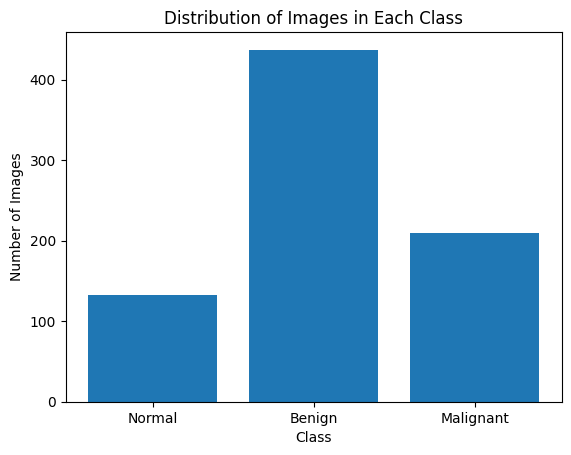

In [7]:
# Get the list of files in each directory
normal_images = os.listdir(normal_path)
benign_images = os.listdir(benign_path)
malignant_images = os.listdir(malignant_path)

# Count the number of images in each class
num_normal_images = len(normal_images)
num_benign_images = len(benign_images)
num_malignant_images = len(malignant_images)

# Print the counts
print("Number of images for each class:")
print("Normal:", num_normal_images)
print("Benign:", num_benign_images)
print("Malignant:", num_malignant_images)

# Plot a bar chart to visualize the distribution
classes = ['Normal', 'Benign', 'Malignant']
counts = [num_normal_images, num_benign_images, num_malignant_images]

plt.bar(classes, counts)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Each Class')
plt.show()

The output above reveals a noticeable class imbalance in the dataset. The benign category is significantly overrepresented compared to the normal and malignant categories. This imbalance will need to be addressed to ensure the model provides a reliable and generalized performance across all classes.

#### Check for any missing or corrupt images

In this section, we perform a quality check on the dataset to ensure that there are no missing or corrupt image files.

In [8]:
from PIL import Image

def check_images(directory):

    corrupt_files = []
    # List all files in the directory
    files = os.listdir(directory)
    for file in files:
        file_path = os.path.join(directory, file)
        try:
            # Try to open the image
            with Image.open(file_path) as img:
                # Check if the image is complete
                img.verify()
                # Additional check: Ensure the image is in 'RGB' mode
                if img.mode != 'RGB':
                    corrupt_files.append(file_path)
        except (IOError, SyntaxError) as e:
            corrupt_files.append(file_path)

    return corrupt_files

# Check each directory for corrupt or missing images
corrupt_normal = check_images(normal_path)
corrupt_benign = check_images(benign_path)
corrupt_malignant = check_images(malignant_path)

# Output the corrupt or missing files
corrupt_files = corrupt_normal + corrupt_benign + corrupt_malignant
if corrupt_files:
    print("Corrupt or missing files:")
    for file_path in corrupt_files:
        print(f" - {file_path}")
else:
    print("No corrupt or missing files found.")


No corrupt or missing files found.


Since there are no currupt or missing images in our dataset, we will proceed to data preparation.

## Data Preparation

In this section, we will perform several preprocessing steps on the images to prepare them for training. This includes:
- Resizing the images to a consistent size
- Normalizing the pixel values to a range between 0 and 1
- Applying data augmentation techniques to increase the variability and size of the training dataset

In [9]:
import numpy as np

# Resize images to 224x224 pixels
img_size = (224, 224)

def load_images(directory):
    images = []
    for fname in os.listdir(directory):
        filepath = os.path.join(directory, fname)
        img = Image.open(filepath).convert("L")  # Convert to grayscale
        img = img.resize(img_size)
        img_array = np.array(img) / 255.0  # Normalize to [0, 1]
        images.append(img_array)
    return np.array(images)

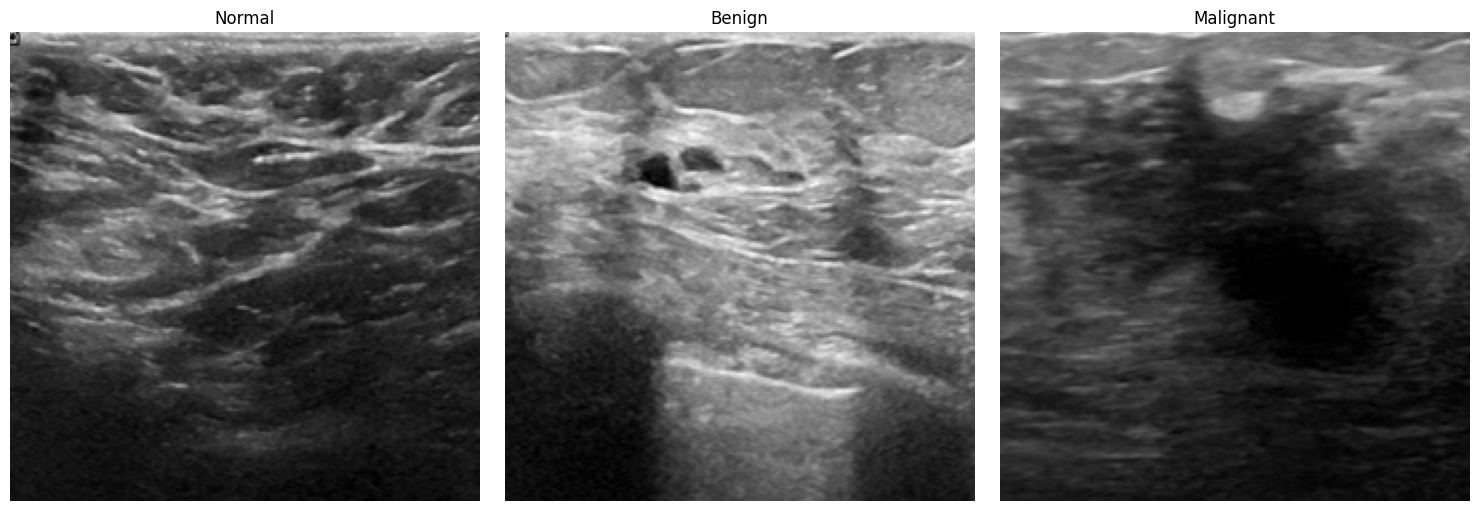

In [10]:
#Displaying the images after resizing and normalizing

# Load images from each category
normal_images = load_images(normal_path)
benign_images = load_images(benign_path)
malignant_images = load_images(malignant_path)

# Display the first image from each category
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(normal_images[0], cmap='gray')
axes[0].set_title('Normal')
axes[0].axis('off')

axes[1].imshow(benign_images[0], cmap='gray')
axes[1].set_title('Benign')
axes[1].axis('off')

axes[2].imshow(malignant_images[0], cmap='gray')
axes[2].set_title('Malignant')
axes[2].axis('off')

plt.tight_layout()
plt.show()

### Creating labels

In [14]:
# Create labels: 0 for normal, 1 for benign, 2 for malignant
normal_labels = np.zeros((normal_images.shape[0],), dtype=int)
benign_labels = np.ones((benign_images.shape[0],), dtype=int)
malignant_labels = np.full((malignant_images.shape[0],), 2)

# Concatenate data and labels
X = np.concatenate([normal_images, benign_images, malignant_images])
y = np.concatenate([normal_labels, benign_labels, malignant_labels])

# Add a channel dimension to the data (needed for CNN)
X = np.expand_dims(X, axis=-1)

X.shape

(780, 224, 224, 1)

In [13]:
# Handling class imbalance
from imblearn.over_sampling import SMOTE

# Create labels: 0 for normal, 1 for benign, 2 for malignant
labels = np.concatenate([normal_labels, benign_labels, malignant_labels])

# Reshape your data to remove the channel dimension
X_2D = X.reshape(X.shape[0], -1)

# Initialize the SMOTE object
smote = SMOTE(sampling_strategy='auto', random_state=42)
# Apply SMOTE to the data
X_resampled, y_resampled = smote.fit_resample(X_2D, labels)

X.shape


(780, 224, 224, 1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [15]:
# Restoring the original size after SMOTE
# Calculate the original number of channels (assuming grayscale images)
num_channels = 1

# Calculate the original image dimensions (assuming 224x224)
original_height = 224
original_width = 224

# Calculate the original shape
original_shape = (X_resampled.shape[0], 224, 224, 1)

# Reshape the data to its original shape
X_resampled = X_resampled.reshape(original_shape)


### Resizing the images

### Normalizing images

### Mask application

In this section we will apply masks to the ultrasound images. This step is crucial for segmenting regions of interest in the images, possibly highlighting areas with cancerous cells.

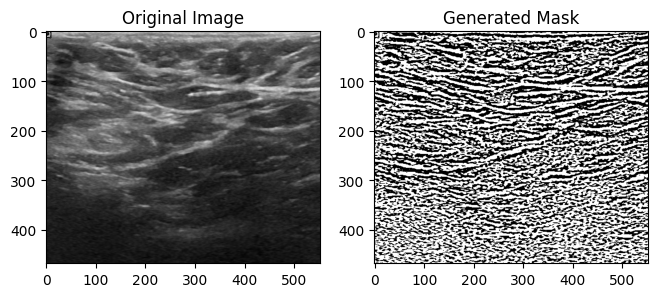

In [19]:
 def apply_masks(images):
     masked_images = []
     for img in images:
         masked_img = cv2.bitwise_and(img, img, mask=img)
         masked_images.append(masked_img)
     return masked_images

 def mask_analysis(image_path):
     try:
         # Get image files in the specified path
         image_files = [os.path.join(image_path, f) for f in os.listdir(image_path) if f.endswith('.png')]

         # Load images in grayscale
         images = [cv2.imread(img_f, cv2.IMREAD_GRAYSCALE) for img_f in image_files]

         # Apply adaptive thresholding to isolate cancerous regions
         masks = []
         for img in images:
             mask = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
             masks.append(mask)

             # Set all non-cancerous regions to black
             mask[mask != 255] = 0

         # Display original images and masked images for the first three images
         for i in range(1):
             plt.figure(figsize=(12, 4))
             plt.subplot(1, 3, 1)
             plt.imshow(images[i], cmap='gray')
             plt.title('Original Image')

             plt.subplot(1, 3, 2)
             plt.imshow(masks[i], cmap='gray')
             plt.title('Generated Mask')

             plt.show()
     except Exception as e:
         print(f"Error processing images in {image_path}: {e}")

 mask_analysis(normal_path)


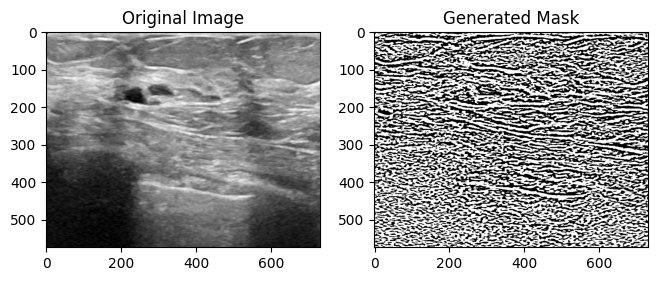

In [20]:
mask_analysis(benign_path)

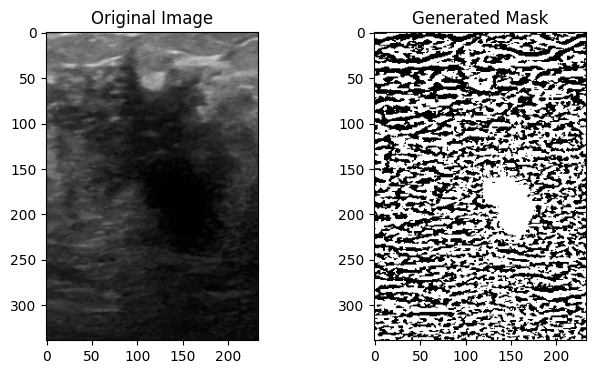

In [21]:
mask_analysis(malignant_path)

### Data augmentation

Next, we perform data augmentation to increase the size and variability of the training dataset.

In [17]:
# Define the parameters for Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

In [22]:
 # Define the parameters for Data Augmentation
 train_datagen = ImageDataGenerator(rescale= 1.0/255, horizontal_flip=True, vertical_flip=True,
                                    shear_range=0.2, zoom_range = 0.2)

 test_datagen = ImageDataGenerator(rescale=1.0/255)

In [27]:
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h))

def flip_image(image, flip_code):
    return cv2.flip(image, flip_code)

def apply_augmentations(image_list):
    augmented_images = []
    for img_path in image_list:
        img = cv2.imread(img_path)
        if img is None:  # Check if the image was loaded successfully
            continue
        #Original_image
        augmented_images.append(img)
        #Rotate by 15 degrees
        augmented_images.append(rotate_image(img, 15))
        #Rotate by -15 degrees
        augmented_images.append(rotate_image(img, -15))
        #Horizontal flip
        augmented_images.append(flip_image(img, 1))
        #Vertical flip
        augmented_images.append(flip_image(img, 0))
    return augmented_images

# Construct the list of image paths based on directories
normal_images_paths = glob.glob(os.path.join(normal_path, '*.png'))
malignant_images_paths = glob.glob(os.path.join(malignant_path, '*.png'))
benign_images_paths = glob.glob(os.path.join(benign_path, '*.png'))

all_image_paths = normal_images_paths + malignant_images_paths + benign_images_paths

# Apply augmentations
augmented_images = apply_augmentations(all_image_paths)

print(f"Total number of augmented images: {len(augmented_images)}")


Total number of augmented images: 3900


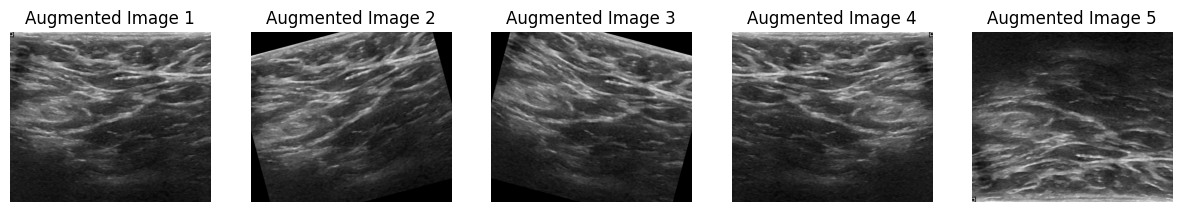

Total number of augmented images: 3900


In [28]:
# Visualize some of the augmented images
plt.figure(figsize=(15, 3))
for i in range(5):  # display first 5 augmented images as an example
    plt.subplot(1, 5, i+1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
    plt.title(f'Augmented Image {i+1}')

plt.show()

# Printing the total number of resized images
print(f"Total number of augmented images: {len(augmented_images)}")

NameError: ignored

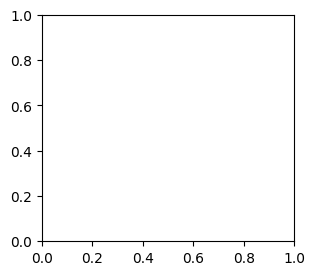

In [31]:
# Visualize original images alongside augmented images
#plt.figure(figsize=(15, 10))
#for i in range(2):  # Display 2 images and their augmented versions as an example
    # Original Image
    #plt.subplot(3, 4, i*2 + 1)
    #plt.imshow(normalized_images[i])
    #plt.axis('off')
    #plt.title(f'Original Image {i+1}')

    # Augmented Image
    #plt.subplot(3, 4, i*2 + 2)
    #plt.imshow(augmented_images[i])
    #plt.axis('off')
    #plt.title(f'Augmented Image {i+1}')

#plt.tight_layout()
#plt.show()

In [ ]:
#import numpy as np
# Function to resize images
#def resize_image(image):
 #   return cv2.resize(image, (224, 224))

# Resize all images in the augmented_images list
#augmented_images = [resize_image(img) for img in augmented_images]

# Convert the list of resized images to a numpy array
#augmented_images_array = np.array(augmented_images)

# Verify the shape
#print(augmented_images_array.shape)

In [ ]:
#Check the shapes of the images in the augmented_images list
#shapes = [img.shape for img in augmented_images_array]

# Get the unique shapes
#unique_shapes = set(shapes)

# If there's more than one unique shape, identify the indices of the images that don't conform to the most common shape
#if len(unique_shapes) > 1:
    #common_shape = max(unique_shapes, key=shapes.count)
   # non_conforming_indices = [i for i, shape in enumerate(shapes) if shape != common_shape]
    #print(f"Most common shape: {common_shape}")
   # print(f"Indices of images with different shapes: {non_conforming_indices}")
#else:
#    print(f"All images have the same shape: {list(unique_shapes)[0]}")


In [ ]:
# Create labels for each class based on the number of images in each directory
#num_normal_images = len(normal_images_paths)
#num_benign_images = len(benign_images_paths)
#num_malignant_images = len(malignant_images_paths)

# Define labels for each class
#normal_labels = [0] * (num_normal_images * 5)
#benign_labels = [1] * (num_benign_images * 5)
#malignant_labels = [2] * (num_malignant_images * 5)

# Combine all the labels into one list
#labels = normal_labels + benign_labels + malignant_labels
#len(labels)

In [ ]:
#labels_array = np.array(labels)
#len(labels_array)

### Splitting the dataset

In this subsection, we will divide our dataset into training, validation, and test sets.

In [33]:
from sklearn.model_selection import train_test_split

# Define the ratios
train_ratio = 0.7
validation_ratio = 0.10
test_ratio = 0.20

# Calculate the sizes of the validation and test sets
validation_size = validation_ratio / (validation_ratio + test_ratio)
test_size = test_ratio / (validation_ratio + test_ratio)

# First split: Split the data into training and a temporary set (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_resampled, y_resampled, test_size=1 - train_ratio, random_state=42, stratify=y_resampled
)

# Second split: Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=test_size, random_state=42, stratify=y_temp
)

# Output the shapes to verify the splits
X_train.shape, X_val.shape, X_test.shape


((917, 224, 224, 1), (131, 224, 224, 1), (263, 224, 224, 1))

In [ ]:
y_train.shape

(917,)

In [34]:
 from sklearn.model_selection import train_test_split

 #Split the data into training, validation, and test sets
 train_ratio = 0.7
 validation_ratio = 0.10
 test_ratio = 0.20

 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

 X_train.shape, X_test.shape


((546, 224, 224, 1), (234, 224, 224, 1))

In [36]:
y_train[0]

array([0., 1., 0.], dtype=float32)

# Modeling

## Baseline CNN Model

In [ ]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=30
)

Epoch 1/30
29/29 [==============================] - 86s 3s/step - loss: 1.4816 - accuracy: 0.4024 - val_loss: 1.0477 - val_accuracy: 0.4046
Epoch 2/30
29/29 [==============================] - 82s 3s/step - loss: 1.0012 - accuracy: 0.4973 - val_loss: 1.0302 - val_accuracy: 0.4427
Epoch 3/30
29/29 [==============================] - 84s 3s/step - loss: 0.9494 - accuracy: 0.5529 - val_loss: 1.0126 - val_accuracy: 0.5573
Epoch 4/30
29/29 [==============================] - 82s 3s/step - loss: 0.8536 - accuracy: 0.6074 - val_loss: 0.8467 - val_accuracy: 0.6183
Epoch 5/30
29/29 [==============================] - 81s 3s/step - loss: 0.7915 - accuracy: 0.6412 - val_loss: 0.8256 - val_accuracy: 0.6489
Epoch 6/30
29/29 [==============================] - 84s 3s/step - loss: 0.7880 - accuracy: 0.6499 - val_loss: 0.8395 - val_accuracy: 0.6489
Epoch 7/30
29/29 [==============================] - 82s 3s/step - loss: 0.7614 - accuracy: 0.6739 - val_loss: 0.9311 - val_accuracy: 0.6336
Epoch 8/30
29/29 [==

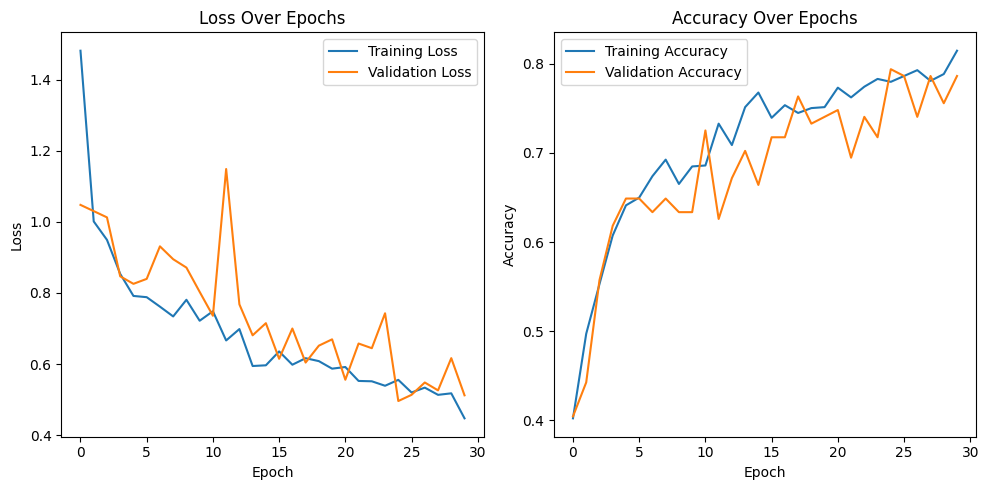

In [ ]:
# Visualize loss and accuracy curves
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plot loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

9/9 [==============================] - 7s 725ms/step - loss: 0.4659 - accuracy: 0.8213
Test Loss: 0.4659
Test Accuracy: 0.8213


In [ ]:
from sklearn.metrics import classification_report

# Predict classes for validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print the classification report
print(classification_report(y_val, y_pred_classes))

5/5 [==============================] - 4s 815ms/step
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        43
           1       0.67      0.84      0.75        44
           2       0.91      0.68      0.78        44

    accuracy                           0.79       131
   macro avg       0.81      0.79      0.79       131
weighted avg       0.81      0.79      0.79       131



Batch size = 16

In [ ]:
# Specifying the number of epochs and batch size
epochs = 30
batch_size = 16

# Training the model
history1 = model.fit(
   datagen.flow(X_train, y_train, batch_size=batch_size),
   validation_data=(X_val, y_val),
   epochs=epochs
)

Epoch 1/30
58/58 [==============================] - 106s 2s/step - loss: 0.6159 - accuracy: 0.7394 - val_loss: 0.5634 - val_accuracy: 0.7634
Epoch 2/30
58/58 [==============================] - 95s 2s/step - loss: 0.5666 - accuracy: 0.7666 - val_loss: 0.6058 - val_accuracy: 0.7328
Epoch 3/30
58/58 [==============================] - 94s 2s/step - loss: 0.5717 - accuracy: 0.7601 - val_loss: 0.6656 - val_accuracy: 0.7328
Epoch 4/30
58/58 [==============================] - 93s 2s/step - loss: 0.5617 - accuracy: 0.7775 - val_loss: 0.5346 - val_accuracy: 0.7710
Epoch 5/30
58/58 [==============================] - 93s 2s/step - loss: 0.5262 - accuracy: 0.7950 - val_loss: 0.5502 - val_accuracy: 0.7786
Epoch 6/30
58/58 [==============================] - 93s 2s/step - loss: 0.5060 - accuracy: 0.8059 - val_loss: 0.4982 - val_accuracy: 0.7786
Epoch 7/30
58/58 [==============================] - 92s 2s/step - loss: 0.4998 - accuracy: 0.8059 - val_loss: 0.4569 - val_accuracy: 0.8168
Epoch 8/30
58/58 [=

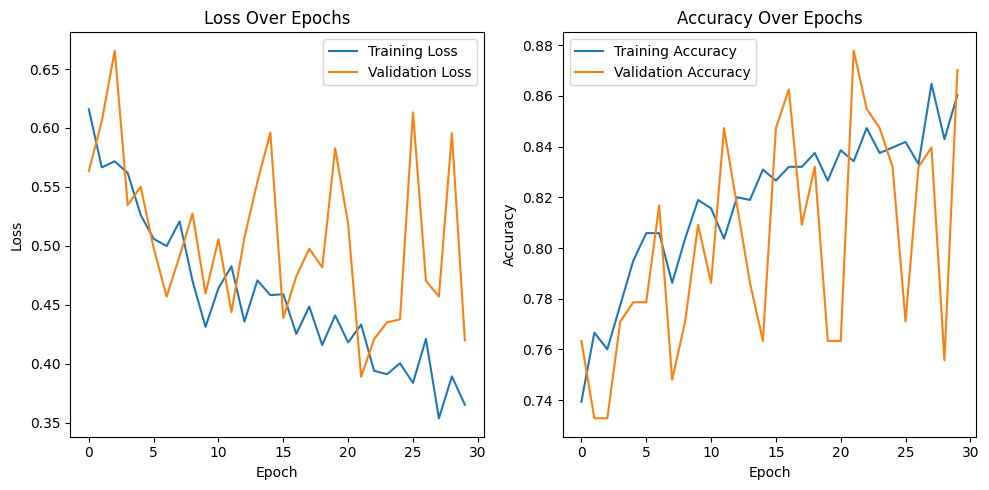

In [ ]:
# Visualize loss and accuracy curves
training_loss = history1.history['loss']
validation_loss = history1.history['val_loss']
training_accuracy = history1.history['accuracy']
validation_accuracy = history1.history['val_accuracy']

# Plot loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

9/9 [==============================] - 14s 1s/step - loss: 0.4602 - accuracy: 0.8631
Test Loss: 0.4602
Test Accuracy: 0.8631


In [ ]:
from sklearn.metrics import classification_report

# Predict classes for validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print the classification report
print(classification_report(y_val, y_pred_classes))


5/5 [==============================] - 2s 467ms/step
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        43
           1       0.80      0.89      0.84        44
           2       0.94      0.73      0.82        44

    accuracy                           0.87       131
   macro avg       0.88      0.87      0.87       131
weighted avg       0.88      0.87      0.87       131



Epochs = 50

In [ ]:
# Specifying the number of epochs and batch size
epochs = 50
batch_size = 16

# Training the model
history2 = model.fit(
   datagen.flow(X_train, y_train, batch_size=batch_size),
   validation_data=(X_val, y_val),
   epochs=epochs
)

Epoch 1/50
58/58 [==============================] - 97s 2s/step - loss: 0.4041 - accuracy: 0.8353 - val_loss: 0.4223 - val_accuracy: 0.8092
Epoch 2/50
58/58 [==============================] - 97s 2s/step - loss: 0.3766 - accuracy: 0.8539 - val_loss: 0.4464 - val_accuracy: 0.8244
Epoch 3/50
58/58 [==============================] - 93s 2s/step - loss: 0.4032 - accuracy: 0.8375 - val_loss: 0.3742 - val_accuracy: 0.8855
Epoch 4/50
58/58 [==============================] - 93s 2s/step - loss: 0.3671 - accuracy: 0.8680 - val_loss: 0.3682 - val_accuracy: 0.8855
Epoch 5/50
58/58 [==============================] - 93s 2s/step - loss: 0.3545 - accuracy: 0.8615 - val_loss: 0.4607 - val_accuracy: 0.8550
Epoch 6/50
58/58 [==============================] - 94s 2s/step - loss: 0.3926 - accuracy: 0.8550 - val_loss: 0.6800 - val_accuracy: 0.7481
Epoch 7/50
58/58 [==============================] - 92s 2s/step - loss: 0.3393 - accuracy: 0.8659 - val_loss: 0.4182 - val_accuracy: 0.8397
Epoch 8/50
58/58 [==

## Base Model with augmentation

In [ ]:
from tensorflow.keras.layers import BatchNormalization

#First Base Model
model2 = Sequential([
    Conv2D(16, 4, padding = 'same', activation = 'relu', input_shape=(224,224,1)),
    MaxPooling2D(),
    Conv2D(32, 4, padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(64, 4, padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.3),
    Dense(64, activation = 'relu'),
    Dropout(0.3),
    Dense(32, activation = 'relu'),
    Dropout(0.3),
    Dense(3, activation = 'softmax')
])

#Compile the model with optimizer and metrics
model2.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

#Review the model summary
model2.summary()

In [ ]:
# Training the model
history1 = model2.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_val, y_val),
    epochs=30
)

In [ ]:
# Visualize loss and accuracy curves
training_loss = history1.history['loss']
validation_loss = history1.history['val_loss']
training_accuracy = history1.history['accuracy']
validation_accuracy = history1.history['val_accuracy']

# Plot loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model2.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
# Predict classes for validation set
y_pred2 = model2.predict(X_val)
y_pred_classes2 = np.argmax(y_pred2, axis=1)

# Print the classification report
print(classification_report(y_val, y_pred_classes2))

In [ ]:
#from sklearn.model_selection import train_test_split

# Split the data into training, validation, and test sets
#train_ratio = 0.7
#validation_ratio = 0.10
#test_ratio = 0.20

# Split the data into a training set and a temporary set for validation and testing
#train_images, temp_images, train_labels, temp_labels = train_test_split(
#    augmented_images_array, labels, test_size=1 - train_ratio, random_state=42
#)

# Split the temporary set into validation and test sets
#validation_images, test_images, validation_labels, test_labels = train_test_split(
 #   temp_images, temp_labels, test_size=test_ratio / (validation_ratio + test_ratio), random_state=42
#)

## Model with early stopping

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model3 = Sequential([
    Conv2D(16, 3, padding = 'same', activation = 'relu', input_shape=(224,224,1)),
    MaxPooling2D(),
    Conv2D(32, 3, padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding = 'same', activation = 'relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dropout(0.3),
    Dense(64, activation = 'relu'),
    Dropout(0.3),
    Dense(32, activation = 'relu'),
    Dropout(0.3),
    Dense(3, activation = 'softmax')
])

model3.compile(optimizer=Adam(learning_rate=0.001),
               loss= 'sparse_categorical_crossentropy',
               metrics=['accuracy'])

model3.summary()

In [ ]:
# Training the model
history2 = model3.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=40,
    callbacks=[early_stopping]
)

In [ ]:
# Visualize loss and accuracy curves
training_loss = history2.history['loss']
validation_loss = history2.history['val_loss']
training_accuracy = history2.history['accuracy']
validation_accuracy = history2.history['val_accuracy']

# Plot loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model3.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
# Predict classes for validation set
y_pred3 = model3.predict(X_val)
y_pred_classes3 = np.argmax(y_pred3, axis=1)

# Print the classification report
print(classification_report(y_val, y_pred_classes3))

In [ ]:
# # Training the model
# history2 = model3.fit(
#     datagen.flow(X_train, y_train, batch_size=32),
#     validation_data=(X_val, y_val),
#     epochs=50
# )

In [ ]:
# # Training the model
# history2 = model3.fit(
#     datagen.flow(X_train, y_train, batch_size=32),
#     validation_data=(X_val, y_val),
#     epochs=30
# )

In [ ]:
# Training the model
history2 = model3.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[early_stopping]
)

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model3.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
# Predict classes for validation set
y_pred3 = model3.predict(X_val)
y_pred_classes3 = np.argmax(y_pred3, axis=1)

# Print the classification report
print(classification_report(y_val, y_pred_classes3))

In [ ]:
# Visualize loss and accuracy curves
training_loss = history2.history['loss']
validation_loss = history2.history['val_loss']
training_accuracy = history2.history['accuracy']
validation_accuracy = history2.history['val_accuracy']

# Plot loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
history2 = model3.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[early_stopping]
)

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model3.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
# Predict classes for validation set
y_pred3 = model3.predict(X_val)
y_pred_classes3 = np.argmax(y_pred3, axis=1)

# Print the classification report
print(classification_report(y_val, y_pred_classes3))

In [ ]:
# Visualize loss and accuracy curves
training_loss = history2.history['loss']
validation_loss = history2.history['val_loss']
training_accuracy = history2.history['accuracy']
validation_accuracy = history2.history['val_accuracy']

# Plot loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
history2 = model3.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[early_stopping]
)

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model3.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
# Predict classes for validation set
y_pred4 = model3.predict(X_val)
y_pred_classes4 = np.argmax(y_pred4, axis=1)

# Print the classification report
print(classification_report(y_val, y_pred_classes4))

In [ ]:
# Visualize loss and accuracy curves
training_loss = history2.history['loss']
validation_loss = history2.history['val_loss']
training_accuracy = history2.history['accuracy']
validation_accuracy = history2.history['val_accuracy']

# Plot loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
history3 = model3.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=20,
    callbacks=[early_stopping]
)

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model3.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
# Predict classes for validation set
y_pred4 = model3.predict(X_val)
y_pred_classes4 = np.argmax(y_pred4, axis=1)

# Print the classification report
print(classification_report(y_val, y_pred_classes4))

In [ ]:
# Visualize loss and accuracy curves
training_loss = history3.history['loss']
validation_loss = history3.history['val_loss']
training_accuracy = history3.history['accuracy']
validation_accuracy = history3.history['val_accuracy']

# Plot loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Model 4: AlexNet

In [ ]:
model4 = Sequential([
    Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model4.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model4.summary()

In [ ]:
# Training the model
history4 = model4.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_val, y_val),
    epochs=30
)

In [ ]:
# Rename the split datasets for further processing
#X_train, y_train = train_images, train_labels
#X_val, y_val = validation_images, validation_labels
#X_test, y_test = test_images, test_labels


# Grid search

In [ ]:
# Define hyperparameters
optimizers = ['adam', 'rmsprop']
batch_sizes = [32, 64]
epochs_list = [10, 20]

grid = [(optimizer, batch_size, epochs) for optimizer in optimizers
        for batch_size in batch_sizes
        for epochs in epochs_list]


In [ ]:
# Perform grid search
best_score = 0
best_params = None

for optimizer, batch_size, epochs in grid:

    # Build and compile the model with the current hyperparameters
    model6 = create_model(optimizer)

    # Fit the model
    history6 = model6.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=0)

    # Get the validation accuracy for the last epoch
    val_accuracy = history6.history['val_accuracy'][-1]

    print(f"Optimizer: {optimizer}, Batch Size: {batch_size}, Epochs: {epochs}, Validation Accuracy: {val_accuracy:.4f}")

    # Update best score and parameters if current model is better
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_params = (optimizer, batch_size, epochs)

print("\nBest Parameters:")
print(f"Optimizer: {best_params[0]}, Batch Size: {best_params[1]}, Epochs: {best_params[2]}, Best Validation Accuracy: {best_score:.4f}")


In [ ]:
# Convert lists to NumPy arrays
#X_train = np.array(X_train)
#y_train = np.array(y_train)
#X_val = np.array(X_val)
#y_val = np.array(y_val)
#X_test = np.array(X_test)
#y_test = np.array(y_test)

### Handling class imbalance

In [ ]:
# from sklearn.utils.class_weight import compute_class_weight

# # Assuming y_train contains the class labels for the training data
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# class_weights_dict = dict(enumerate(class_weights))


## Modeling

In [ ]:
# from tensorflow.keras.layers import BatchNormalization

# #First Base Model
# model = Sequential([
#     Conv2D(16, 4, padding = 'same', activation = 'relu', input_shape=(224,224,3)),
#     MaxPooling2D(),
#     Conv2D(32, 4, padding = 'same', activation = 'relu'),
#     MaxPooling2D(),
#     Conv2D(64, 4, padding = 'same', activation = 'relu'),
#     MaxPooling2D(),
#     BatchNormalization(),
#     Flatten(),
#     Dense(128, activation = 'relu'),
#     Dropout(0.3),
#     Dense(64, activation = 'relu'),
#     Dropout(0.3),
#     Dense(32, activation = 'relu'),
#     Dropout(0.3),
#     Dense(3, activation = 'softmax')
# ])

# #Compile the model with optimizer and metrics
# model.compile(optimizer = 'adam',
#               loss = 'sparse_categorical_crossentropy',
#               metrics = ['accuracy'])

# #Review the model summary
# model.summary()

In [ ]:
# Define the model
#model = Sequential([
 #   Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # Convolutional layer
  #  MaxPooling2D(pool_size=(2, 2)),  # Pooling layer
   # Flatten(),  # Flatten layer
    #Dense(128, activation='relu'),  # Fully connected layer
    #Dropout(0.5),
    #Dense(3, activation='softmax')  # Output layer with the 3 classes
#])

# Compile the model
#model.compile(optimizer='adam',
           #   loss='sparse_categorical_crossentropy',
            #  metrics=['accuracy'])

# Summary of the model
#model.summary()


In [ ]:
# print(f"X_train shape: {X_train.shape}, dtype: {X_train.dtype}")
# print(f"y_train shape: {y_train.shape}, dtype: {y_train.dtype}")
# print(f"X_val shape: {X_val.shape}, dtype: {X_val.dtype}")
# print(f"y_val shape: {y_val.shape}, dtype: {y_val.dtype}")
# print(f"X_test shape: {X_test.shape}, dtype: {X_test.dtype}")
# print(f"y_test shape: {y_test.shape}, dtype: {y_test.dtype}")


### Training the model

In [ ]:
# # Parameters for training
# epochs = 10
# batch_size = 32

# # Train the model
# history = model.fit(
#     X_train, y_train,
#     epochs=epochs,
#     batch_size=batch_size,
#     validation_data=(X_val, y_val),
#     verbose=2
# )

In [ ]:
# Train the model
#history = model.fit(
    #X_train, y_train,
    #epochs=20,
    #batch_size=32,
    #validation_data=(X_val, y_val)
#)

In [ ]:
#from sklearn.metrics import classification_report

# Predict classes for validation set
#y_pred = model.predict(X_val)
#y_pred_classes = np.argmax(y_pred, axis=1)

# Print the classification report
#print(classification_report(y_val, y_pred_classes))


In [ ]:
# from sklearn.metrics import classification_report

# def report(model, aug = False):
#     if aug:
#         xtest = X_test
#         y_true = y_test
#     else:
#         xtest = X_test
#         y_true = y_test
#     y_pred = []
#     for i in model.predict(xtest,batch_size=10,verbose=0):
#         y_pred.append(np.argmax(i))
#     print(classification_report(y_true, y_pred, target_names= ['normal','benign','malignant']))

In [ ]:
# # Access the history object returned from model.fit()
# training_loss = history.history['loss']
# validation_loss = history.history['val_loss']
# training_accuracy = history.history['accuracy']
# validation_accuracy = history.history['val_accuracy']

# # Plot loss
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(training_loss, label='Training Loss')
# plt.plot(validation_loss, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Loss Over Epochs')
# plt.legend()

# # Plot accuracy
# plt.subplot(1, 2, 2)
# plt.plot(training_accuracy, label='Training Accuracy')
# plt.plot(validation_accuracy, label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Accuracy Over Epochs')
# plt.legend()

# plt.tight_layout()
# plt.show()


**Observation**:

After analyzing the training progress, it's evident that the validation loss follows a descending trend initially but begins to rise after the third epoch. Similarly, the validation accuracy maintains stability and then declines following the third epoch.

**Further Improvements to the model:**

In order to enhance the model's performance, several parameter adjustments will be implemented.
- The first technique to be introduced is ***early stopping***, a strategy that entails vigilant monitoring of the model's performance on the validation dataset throughout training. If the observed performance ceases to improve or demonstrates signs of deterioration, the training process is ceased. The aim is to thwart the model from learning noise in the data and to select the point of optimal generalization.

- The second enhancement involves the integration of an optimizer into the model.

- Lastly, the ***dropout*** regularization technique will be employed to mitigate overfitting. This technique involves the random omission (i.e., setting to zero) of a specific percentage of neurons or units within a layer during both forward and backward passes of training. This measured exclusion fosters better generalization and improved resilience against overfitting.

In [ ]:
# # Evaluate the model
# test_loss, test_accuracy = model.evaluate(X_test, y_test)
# print(f"Test Loss: {test_loss:.4f}")
# print(f"Test Accuracy: {test_accuracy:.4f}")


In [ ]:
#report(model)        #Classification Report

## Model 2

In [ ]:
#model2 = Sequential([
 #   layers.Conv2D(16, 3, padding = 'same', activation = 'relu', input_shape=(224,224,3)),
  #  layers.MaxPooling2D(),
   # layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    #layers.MaxPooling2D(),
    #layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    #layers.MaxPooling2D(),
    #layers.BatchNormalization(),
    #layers.Flatten(),
    #layers.Dense(128, activation = 'relu'),
    #layers.Dropout(0.3),
    #layers.Dense(64, activation = 'relu'),
    #layers.Dropout(0.3),
    #layers.Dense(32, activation = 'relu'),
    #layers.Dropout(0.3),
    #layers.Dense(3, activation = 'softmax')
#])

#Compile the model with optimizer and metrics
#model2.compile(optimizer = 'adam',
 #             loss = 'sparse_categorical_crossentropy',
  #            metrics = ['accuracy'])

#Review the model summary
#model2.summary()

To prevent overfitting and improve efficiency, the model is trained with the early stopping technique. Early stopping monitors the validation loss and halts training if the loss doesn't improve over a certain number of epochs (patience). This helps the model to avoid excessive training that may lead to overfitting.

In [ ]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# model2 = Sequential([
#     Conv2D(16, 3, padding = 'same', activation = 'relu', input_shape=(224,224,3)),
#     MaxPooling2D(),
#     Conv2D(32, 3, padding = 'same', activation = 'relu'),
#     MaxPooling2D(),
#     Conv2D(64, 3, padding = 'same', activation = 'relu'),
#     MaxPooling2D(),
#     BatchNormalization(),
#     Flatten(),
#     Dense(128, activation = 'relu'),
#     Dropout(0.3),
#     Dense(64, activation = 'relu'),
#     Dropout(0.3),
#     Dense(32, activation = 'relu'),
#     Dropout(0.3),
#     Dense(3, activation = 'softmax')
# ])

# model2.compile(optimizer=Adam(learning_rate=0.001),
#                loss= 'sparse_categorical_crossentropy',
#                metrics=['accuracy'])

# model2.summary()

In [ ]:
#history2 = model2.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping])

In [ ]:
# # Access the history object returned from model.fit()
# training_loss = history2.history['loss']
# validation_loss = history2.history['val_loss']
# training_accuracy = history2.history['accuracy']
# validation_accuracy = history2.history['val_accuracy']

# # Plot loss
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(training_loss, label='Training Loss')
# plt.plot(validation_loss, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Loss Over Epochs')
# plt.legend()

# # Plot accuracy
# plt.subplot(1, 2, 2)
# plt.plot(training_accuracy, label='Training Accuracy')
# plt.plot(validation_accuracy, label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Accuracy Over Epochs')
# plt.legend()

# plt.tight_layout()
# plt.show()

In [ ]:
# # Evaluate the model
# test_loss, test_accuracy = model2.evaluate(X_test, y_test)
# print(f"Test Loss: {test_loss:.4f}")
# print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
#report(model2)        #Classification Report

## Model 3

In [ ]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# model3 = Sequential([
#     Conv2D(16, 3, padding = 'same', activation = 'relu', input_shape=(224,224,3)),
#     MaxPooling2D(),
#     Conv2D(32, 3, padding = 'same', activation = 'relu'),
#     MaxPooling2D(),
#     Conv2D(64, 3, padding = 'same', activation = 'relu'),
#     MaxPooling2D(),
#     BatchNormalization(),
#     Flatten(),
#     Dense(128, activation = 'relu'),
#     Dropout(0.3),
#     Dense(64, activation = 'relu'),
#     Dropout(0.3),
#     Dense(32, activation = 'relu'),
#     Dropout(0.3),
#     Dense(3, activation = 'softmax')
# ])

# model3.compile(optimizer=Adam(learning_rate=0.01),
#                loss= 'sparse_categorical_crossentropy',
#                metrics=['accuracy'])

# model3.summary()

In [ ]:
#history3 = model3.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[early_stopping])

In [ ]:
# training_loss = history3.history['loss']
# validation_loss = history3.history['val_loss']
# training_accuracy = history3.history['accuracy']
# validation_accuracy = history3.history['val_accuracy']

# # Plot loss
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(training_loss, label='Training Loss')
# plt.plot(validation_loss, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Loss Over Epochs')
# plt.legend()

# # Plot accuracy
# plt.subplot(1, 2, 2)
# plt.plot(training_accuracy, label='Training Accuracy')
# plt.plot(validation_accuracy, label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Accuracy Over Epochs')
# plt.legend()

# plt.tight_layout()
# plt.show()

In [ ]:
# # Evaluate the model
# test_loss, test_accuracy = model3.evaluate(X_test, y_test)
# print(f"Test Loss: {test_loss:.4f}")
# print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
#report(model3)

In [ ]:
# # Callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# model4 = Sequential([
#     Conv2D(32, 3, padding='same', activation='relu', input_shape=(224,224,3)),
#     BatchNormalization(),
#     MaxPooling2D(),
#     Conv2D(64, 3, padding='same', activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D(),
#     Conv2D(128, 3, padding='same', activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D(),
#     Flatten(),
#     Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     Dropout(0.5),
#     Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     Dropout(0.5),
#     Dense(3, activation='softmax')
# ])

# model4.compile(optimizer=Adam(learning_rate=0.001),
#                loss='sparse_categorical_crossentropy',
#                metrics=['accuracy'])

# history4 = model4.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),
#                       callbacks=[early_stopping, reduce_lr])


In [ ]:
# model5 = Sequential([
#     Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
#     BatchNormalization(),
#     MaxPool2D(pool_size=(3,3), strides=(2,2)),
#     Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
#     BatchNormalization(),
#     MaxPool2D(pool_size=(3,3), strides=(2,2)),
#     Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
#     BatchNormalization(),
#     Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
#     BatchNormalization(),
#     Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
#     BatchNormalization(),
#     MaxPool2D(pool_size=(3,3), strides=(2,2)),
#     Flatten(),
#     Dense(4096, activation='relu'),
#     Dropout(0.5),
#     Dense(4096, activation='relu'),
#     Dropout(0.5),
#     Dense(3, activation='softmax')
# ])

# model5.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model5.summary()

In [ ]:
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.layers import GlobalAveragePooling2D

# # Load the pre-trained VGG16 model with imagenet weights
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Freeze the layers in the base model
# for layer in base_model.layers:
#     layer.trainable = False

# # Create a new model by adding custom layers on top of the base model
# model3 = Sequential()
# model3.add(base_model)
# model3.add(GlobalAveragePooling2D())
# model3.add(Dense(256, activation='relu'))
# model3.add(Dense(128, activation='relu'))
# model3.add(Dense(64, activation='relu'))
# model3.add(Dense(3, activation='softmax'))

# # Compile the model
# model3.compile(optimizer=Adam(learning_rate=0.01),
#                loss=SparseCategoricalCrossentropy(),
#                metrics=['accuracy'])

# # Train the model
# history3 = model3.fit(X_train, y_train,
#                       epochs=20,
#                       validation_data=(X_val, y_val),
#                       callbacks=[early_stopping])